In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from scipy.stats import norm
from tqdm.notebook import tqdm

In [9]:
#load datasets
eu_df = pd.read_csv("european_index.csv")
rf_df = pd.read_csv("FEDFUNDS.csv")
european_index_df = pd.read_csv("ndx_historical.csv")

In [20]:
apple = eu_df[eu_df['symbol'].str.contains("AAPL")]
apple.head()

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,Close/Last,FEDFUNDS,volatility


In [10]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")
rf_df.head()

,DATE,FEDFUNDS
0,2013-02-01,0.15
1,2013-03-01,0.14
2,2013-04-01,0.15
3,2013-05-01,0.11
4,2013-06-01,0.09


In [24]:
# How many intervals to look back for when calculating volatility
volatility_intervals = 100

european_index_df["Date"] = pd.to_datetime(european_index_df["Date"])
european_index_df["volatility"] = european_index_df["Close/Last"].rolling(volatility_intervals).std() / european_index_df["Close/Last"]
european_index_df = european_index_df.dropna()
european_index_df.head()

,Date,Close/Last,Volume,Open,High,Low,volatility
198,2022-06-09,12269.78,--,12543.37,12666.41,12265.86,0.062004
199,2022-06-08,12615.13,--,12682.81,12776.65,12578.55,0.060282
200,2022-06-07,12711.68,--,12456.49,12737.30,12413.56,0.059930
201,2022-06-06,12599.63,--,12745.89,12804.46,12534.58,0.060227
202,2022-06-03,12548.03,--,12650.38,12724.81,12505.76,0.060365


In [90]:
eu_df = eu_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df = pd.merge(eu_df, european_index_df, left_on="date", right_on="Date")
eu_df = eu_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style", "tte", "Close/Last", "FEDFUNDS", "volatility"]]
eu_df.head()

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,Close/Last,FEDFUNDS,volatility
0,2015-01-02,NDX 150109C3100000,2015-01-09,C,3100000,1124.9,1134.0,E,7 days,4230.24,0.11,0.027469
1,2015-01-02,NDX 150109C3125000,2015-01-09,C,3125000,1099.9,1109.0,E,7 days,4230.24,0.11,0.027469
2,2015-01-02,NDX 150109C3150000,2015-01-09,C,3150000,1074.9,1084.0,E,7 days,4230.24,0.11,0.027469
3,2015-01-02,NDX 150109C3175000,2015-01-09,C,3175000,1049.9,1059.0,E,7 days,4230.24,0.11,0.027469
4,2015-01-02,NDX 150109C3200000,2015-01-09,C,3200000,1024.9,1034.0,E,7 days,4230.24,0.11,0.027469


In [93]:
def black_scholes(S, K, T, r, sigma, option_type, num_simulations=1000000, plot=True, num_paths_to_plot=25):
    """
    Calculates the Black-Scholes option price for a European call or put option.

    Parameters:
    S : float Current stock price
    K : float Strike price
    T : float Time to expiration in years
    r : float Annualized risk-free interest rate
    sigma : float Annualized volatility of returns
    option_type : str 'call' or 'put'

    Returns: float Option price according to the Black-Scholes model
    """

    # Generate random numbers for the Monte Carlo simulation (decided to use normal distribution for this since it's clean)
    rand_nums = np.random.standard_normal(size=(num_simulations, int(T * 365)))

    # Calculate the stock price at maturity for each simulation
    # Used Geometric Brownian Motion assuming the stock has the log-normal property (Ch. 14.3-14.7)
    dt = T / rand_nums.shape[1]
    price_at_maturity = S * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * rand_nums, axis=1))
    if plot:
        # Plot sample stock price paths using matplotlib
        plt.figure(figsize=(10, 6))
        #Get time_step interval in even spacing for matplotlib
        time_steps = np.linspace(0, T, rand_nums.shape[1] + 1)
        #Select a random sample of our 2D generated GBM plots to plot
        selected_paths = np.random.choice(num_simulations, num_paths_to_plot, replace=False)
        for i in selected_paths:
            plt.plot(time_steps, np.concatenate(([S], price_at_maturity[i, :])))
        plt.hlines(K, xmin=0, xmax=time_steps[-1], colors="red")
        plt.xlabel('Time (years)')
        plt.ylabel('Stock Price')
        plt.title('Sample Stock Price Paths')
        plt.grid(True)
        plt.show()

    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'Call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    elif option_type == 'Put':
        option_price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price

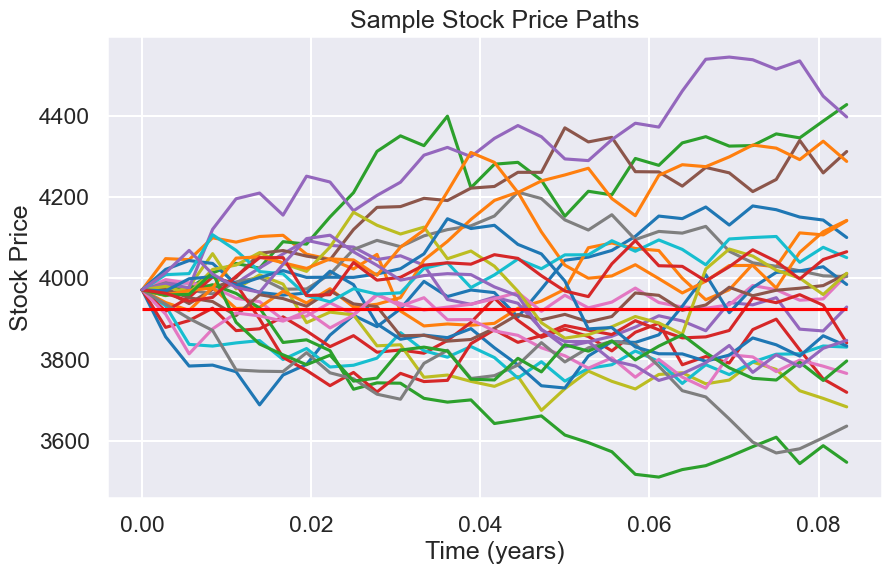

The estimated price of the European Put for SPX put expiring in 0.08333333333333333 years is $65.64


In [94]:
# Example usage with a random SPX options contract currently
S = 3970.99          # Initial stock price
K = 3925.00           # Strike price
T = (1/12)            # Time to maturity (in years)
r = 0.0338            # Risk-free interest rate
sigma = 0.2012        # Volatility of the underlying asset
option_type = 'Put'

option_price = black_scholes(S, K, T, r, sigma, option_type, plot=True)
print(f"The estimated price of the European {option_type} for SPX put expiring in {T} years is ${option_price:.2f}")

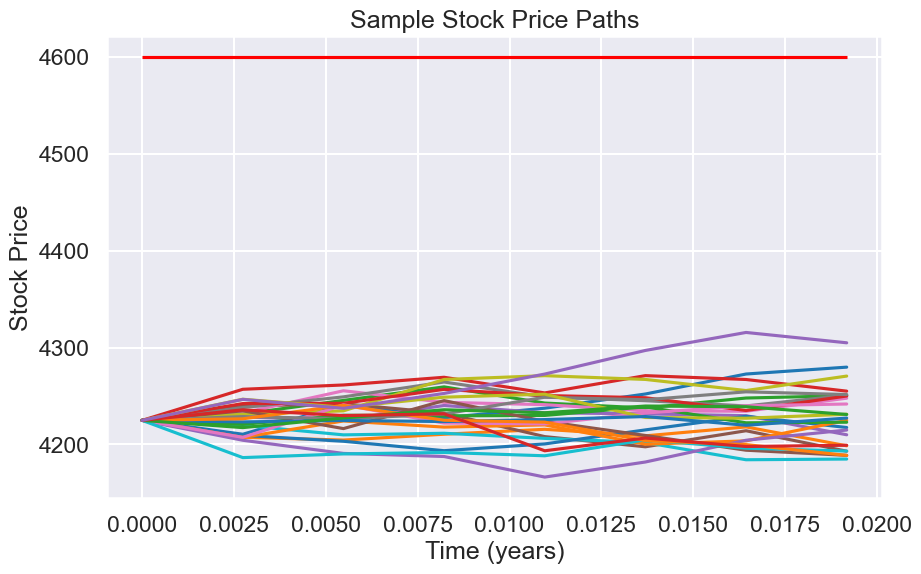

375.13649480870754

In [95]:
row = eu_df.iloc[658767]
black_scholes(
    row["Close/Last"],
    row["strike_price"] / 1000,
    row["tte"].days / 365,
    row["FEDFUNDS"] / 100,
    row["volatility"],
    option_type= True if row["cp_flag"] == "C" else "Put",
    plot=True
)